# Training Models

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Bidirectional
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.utils.class_weight import compute_class_weight
from gensim.models import Word2Vec

# Hyperparameters
maxlen = 100
embedding_dim = 300  # Dimensionality of Word2Vec embeddings
lstm_units = 128
num_lstm_layers = 2  # Number of BI-LSTM layers
batch_size = 32
epochs = 10

class_data = pd.read_csv("training_dataset.csv")

# Tokenize and pad sequences
X_title = class_data['Title_tokens'].apply(lambda x: eval(x)).values
X_body = class_data['Body_tokens'].apply(lambda x: eval(x)).values
X_combined = [title + body for title, body in zip(X_title, X_body)]

X_train, X_test, y_train, y_test = train_test_split(X_combined, class_data['LabelNum'].values, test_size=0.2, random_state=42)

class_tokenizer = Tokenizer()
class_tokenizer.fit_on_texts(X_combined)

X_train_seq = class_tokenizer.texts_to_sequences(X_train)
X_test_seq = class_tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen, padding='post', truncating='post')

word2vec_model = Word2Vec(sentences=X_combined, vector_size=embedding_dim, window=5, min_count=1, workers=4)

# Model architecture
class_model = Sequential()

class_model.add(Embedding(input_dim=len(class_tokenizer.word_index) + 1, 
                          output_dim=embedding_dim, 
                          weights=[np.vstack([np.zeros(embedding_dim), word2vec_model.wv.vectors])], 
                          input_length=maxlen, trainable=False))

for _ in range(num_lstm_layers):
    class_model.add(Bidirectional(LSTM(units=lstm_units, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))

class_model.add(Bidirectional(LSTM(units=lstm_units, dropout=0.2, recurrent_dropout=0.2)))

class_model.add(Dense(1, activation='sigmoid'))

class_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: w for i, w in enumerate(class_weights)}

# Train the model
class_model.fit(X_train_pad, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1, class_weight=class_weights_dict)

# Evaluate the model
loss, accuracy = class_model.evaluate(X_test_pad, y_test)
print("Test Accuracy:", accuracy)




Epoch 1/10


1156/1156 [==============================] - 897s 762ms/step - loss: 0.1083 - accuracy: 0.9645 - val_loss: 0.0727 - val_accuracy: 0.9786
Epoch 2/10
1156/1156 [==============================] - 830s 718ms/step - loss: 0.0732 - accuracy: 0.9760 - val_loss: 0.0723 - val_accuracy: 0.9781
Epoch 3/10
1156/1156 [==============================] - 837s 724ms/step - loss: 0.0646 - accuracy: 0.9786 - val_loss: 0.0647 - val_accuracy: 0.9764
Epoch 4/10
1156/1156 [==============================] - 848s 734ms/step - loss: 0.0564 - accuracy: 0.9809 - val_loss: 0.0720 - val_accuracy: 0.9754
Epoch 5/10
1156/1156 [==============================] - 863s 747ms/step - loss: 0.0527 - accuracy: 0.9818 - val_loss: 0.0601 - val_accuracy: 0.9779
Epoch 6/10
1156/1156 [==============================] - 890s 770ms/step - loss: 0.0450 - accuracy: 0.9847 - val_loss: 0.0707 - val_accuracy: 0.9737
Epoch 7/10
1156/1156 [==============================] - 861s 745ms/step - loss: 0.0384 - accuracy: 0.9859 -

In [2]:
user_input = input("Enter: ")

user_input_seq = class_tokenizer.texts_to_sequences([user_input])

user_input_pad = pad_sequences(user_input_seq, maxlen=100, padding='post', truncating='post')

print("User input: ", user_input)

predicted_label = class_model.predict(user_input_pad)

predicted_label_binary = 1 if predicted_label > 0.5 else 0
predicted_label_st = "Android" if predicted_label_binary == 0 else "IOS"


print("Predicted Label: ", predicted_label_st)

User input:  `pizza
1/1 [==============================] - 4s 4s/step
Predicted Label:  IOS


322/322 [==============================] - 30s 94ms/step


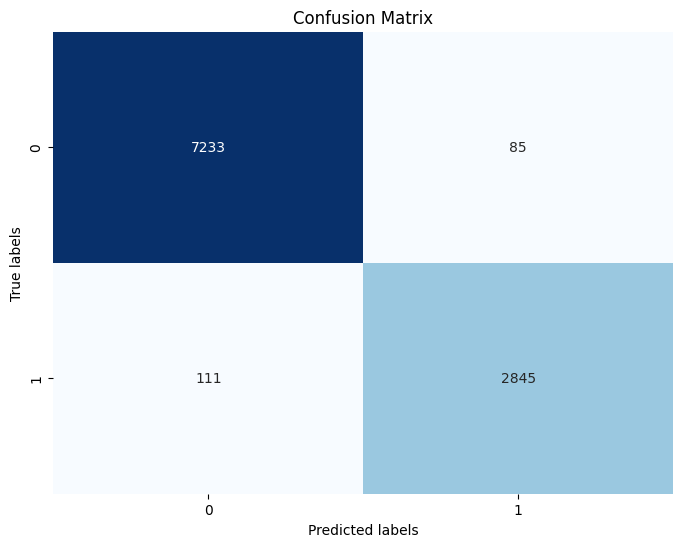

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      7318
           1       0.97      0.96      0.97      2956

    accuracy                           0.98     10274
   macro avg       0.98      0.98      0.98     10274
weighted avg       0.98      0.98      0.98     10274



In [96]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

predictions = class_model.predict(X_test_pad)
y_pred = (predictions > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Calculate classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


In [5]:
my_dict = {
    "x": "John",
    "x": 'ss',
    "x": 2,
    "city": "New York"
}

print("Name:", my_dict["x"])


Name: 2
